# inference


In [1]:
import jax

jax.config.update("jax_enable_x64", True)

import tinygp
from tinygp import GaussianProcess
from tinygp import kernels

#stock imports
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import pickle
import scipy
from scipy import constants
import os, sys
from astropy.io import ascii
import astropy.constants
from cmcrameri import cm

##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

#script imports
scripts_path = "scripts" #os.path.join(repo_root, 'scripts')
sys.path.append(scripts_path)

import prior_funcs, utils
from pitchfork_funcs import emulator
from pitchfork_funcs import nested_sampler



import logging
logging.getLogger('ultranest').setLevel(logging.WARNING)

os.environ["CUDA_VISIBLE_DEVICES"]="1"

physical_devices = tf.config.list_physical_devices("GPU") 

#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpu0usage = tf.config.experimental.get_memory_info("GPU:0")["current"]

2025-04-17 10:18:07.533120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-17 10:18:07.544356: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-17 10:18:07.547866: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-17 10:18:08.103350: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Import pitchfork

In [2]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork_path = "pitchfork/"

pitchfork = emulator(pitchfork_name, file_path=pitchfork_path)


with open(pitchfork_path+ pitchfork_name+'.pkl', 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


## save observed/published parameters

## define priors

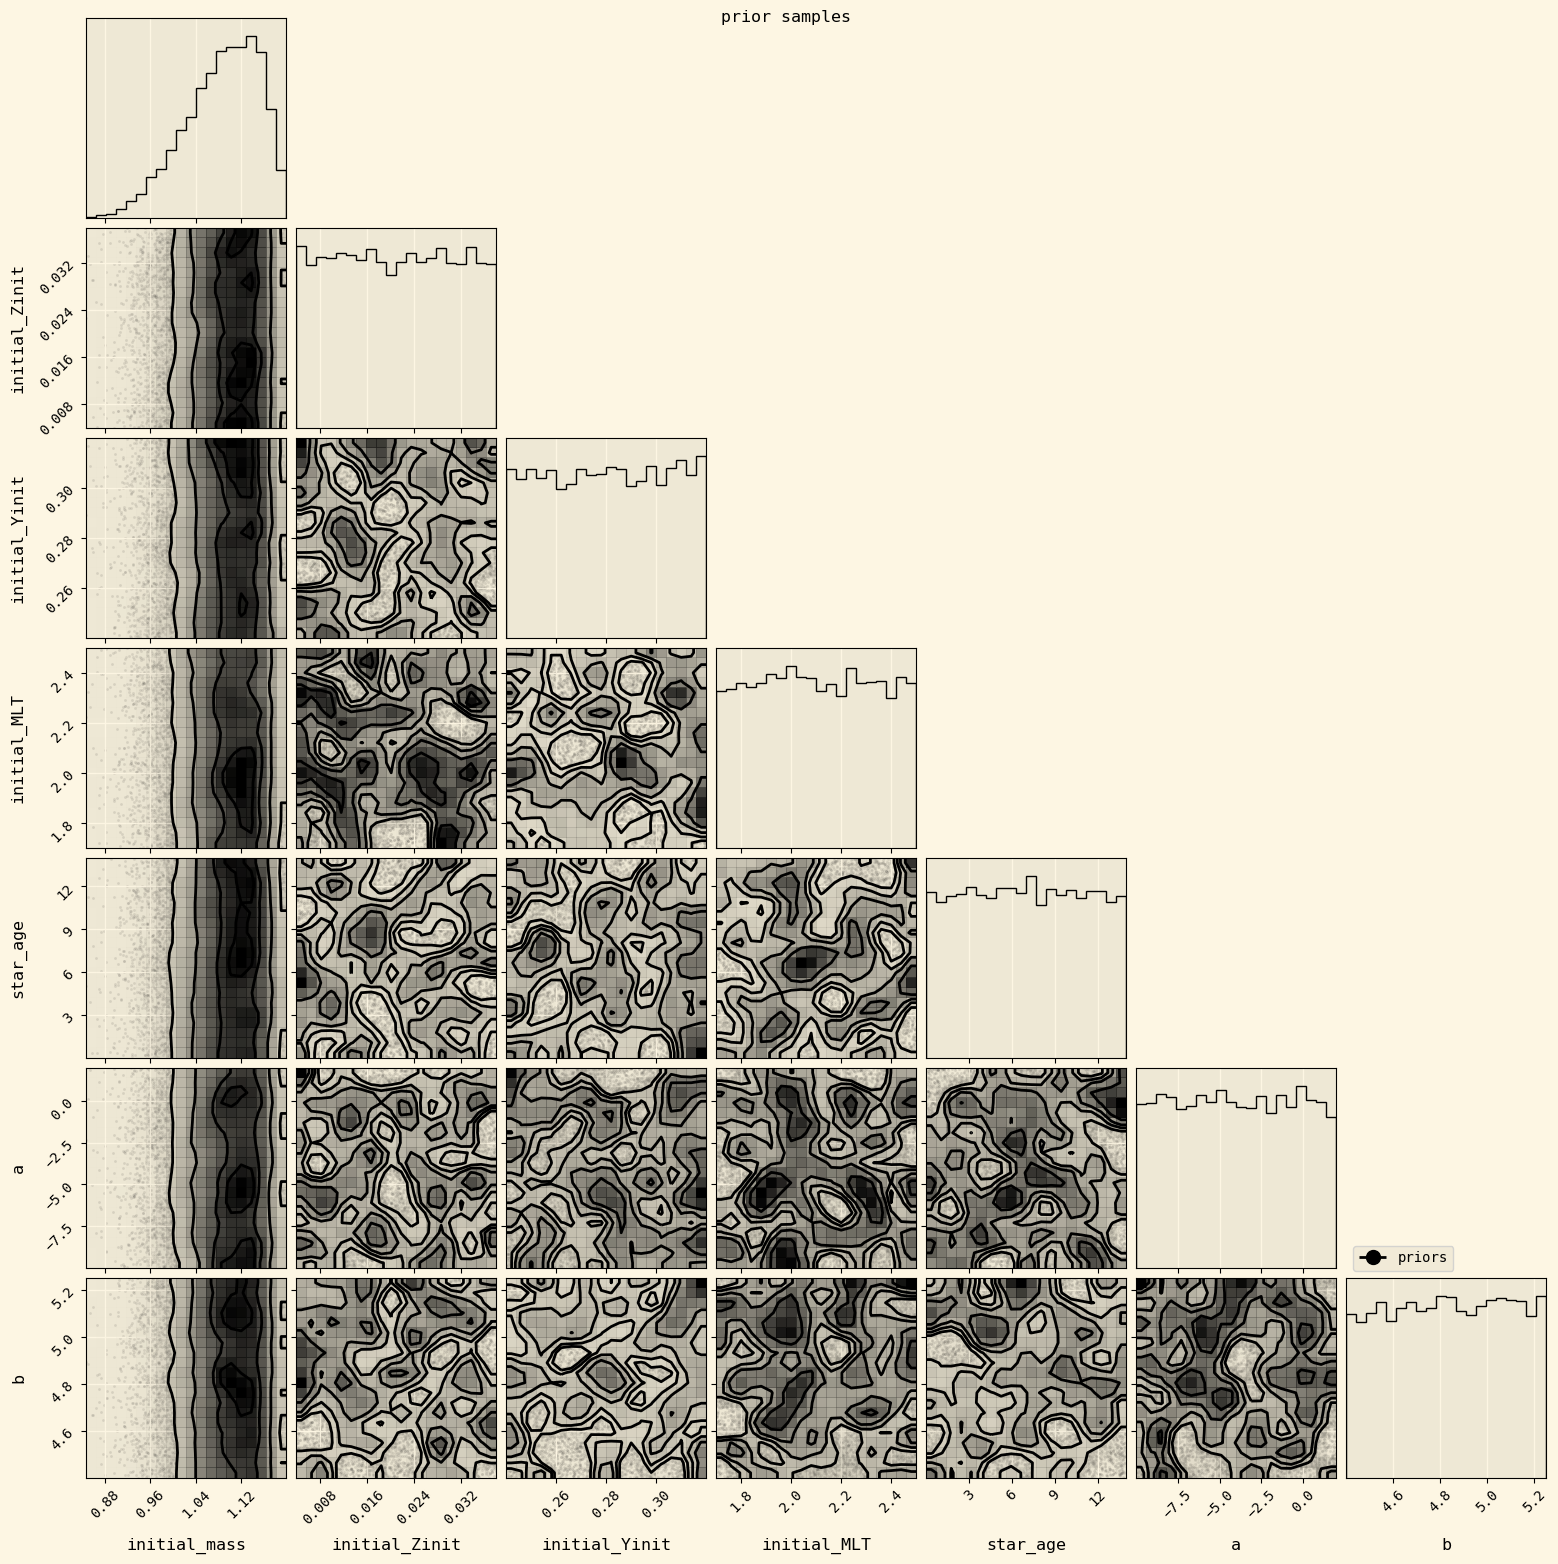

In [3]:
labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=5, b=2)

Zinit_prior = prior_funcs.custom_uniform_prior(0.004, 0.038)

Yinit_prior = prior_funcs.custom_uniform_prior(0.24, 0.32)

MLT_prior = prior_funcs.custom_uniform_prior(1.7, 2.5)

age_prior = prior_funcs.custom_uniform_prior(0.03, 14)

a_prior = prior_funcs.custom_uniform_prior(-10, 2)

b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)

priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

size = 10000
plot_prior_samples = np.array([prior.rvs(size=size) for prior in priors])
legend_labels = []
corner_color = 'black'
corner.corner(plot_prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
legend_labels = legend_labels + [Line2D([0], [0], marker='o', color =corner_color, markerfacecolor = corner_color, markersize=10, label='priors')]
plt.suptitle('prior samples')
plt.legend(handles=legend_labels, bbox_to_anchor=(0., 1.0, 1., .0), loc=0)
plt.show()

## pre-sampling step
define relevant covariance matrices for likelihood, inputs and outputs etc

In [21]:
star_name = 'blossom'
star_colour = '#33ACE3'

star_json = f'powerpuff/{star_name}/{star_name}_l0.json'

star_df = pd.read_json(star_json).dropna(axis=1)

star_vals_df = star_df.iloc[[0]]

star_uncs_df = star_df.iloc[[1]]

star_obs_vals_df = star_vals_df.drop(['dnu', 'nu_max'], axis=1)

star_obs_uncs_df = star_uncs_df.drop(['dnu', 'nu_max'], axis=1)

nu_max = star_df["nu_max"].values[0]

### obs matrix
star_obs_vals_df = star_vals_df.drop(['dnu', 'nu_max'], axis=1)

star_obs_uncs_df = star_uncs_df.drop(['dnu', 'nu_max'], axis=1)

sigma_obs = (star_obs_uncs_df.values[0]*star_obs_uncs_df.values[0])*(np.identity(len(star_obs_uncs_df.values[0])))

### nn matrix
with open(pitchfork_path+ "/emulator_cov.pkl", 'rb') as fp:
     sigma_nn = pickle.load(fp)

n_min = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[0].replace('nu_0_',''))
n_max = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[-1].replace('nu_0_',''))

sigma_nn_mask = np.zeros(len(sigma_nn), dtype=bool)
sigma_nn_mask[:3] = True
sigma_nn_mask[n_min-3:n_max-2] = True

sigma_nn_cropped = sigma_nn[:,sigma_nn_mask][sigma_nn_mask,:]

### gp matrix
obs_freqs = star_vals_df[[f"nu_0_{i}" for i in range(n_min, n_max+1)]].iloc[0].values.flatten()

dnu = star_df['dnu'].values[0]

kernel = 4*kernels.ExpSquared(scale=7*dnu)

gp = GaussianProcess(kernel, obs_freqs, diag=1e-12)

gp_cov = tinygp.solvers.DirectSolver.init(kernel, obs_freqs, noise=tinygp.noise.Dense(value=np.zeros((len(obs_freqs),len(obs_freqs))))).covariance()

gp_cov_padded = np.pad(gp_cov, (3,0))

# add covariance matrices
sigma = sigma_nn_cropped + sigma_obs + gp_cov_padded

sigma_inv = np.linalg.inv(sigma)

_, log_sigma_det = np.linalg.slogdet(sigma)

In [10]:
%%time

import logging
logging.getLogger('ultranest').setLevel(logging.WARNING)

    
ndraw_min=2**16
ndraw_max=2**19
min_num_live_points = 400

#print(star_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].iloc[[0]].to_markdown(index=False))
sampler = nested_sampler(priors=priors, observed_vals=star_obs_vals_df.values[0], pitchfork=pitchfork,log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, nu_max = nu_max, n_min=n_min, n_max=n_max, logl_scale=1)
results = sampler(ndraw_min, ndraw_max).run(min_num_live_points=min_num_live_points, cluster_num_live_points=.1*min_num_live_points, frac_remain=.05)#, max_ncalls=5e6)

with open(f'powerpuff/{star_name}/{star_name}_results/{star_name}_samples.pkl', 'wb') as fp:
    pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)

sampler.cleanup()

del results

/home/oxs235/miniconda3/envs/jaxtf/lib/python3.12/site-packages/ultranest/integrator.py:1896: UserWarning: Sampling from region seems inefficient (0/65536 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  u, v, logl, nc, quality = self._refill_samples(Lmin, ndraw, nit)


CPU times: user 4min 50s, sys: 6.83 s, total: 4min 57s*| it/evals=5973/694139 eff=0.5226% N=400 
Wall time: 4min 43s


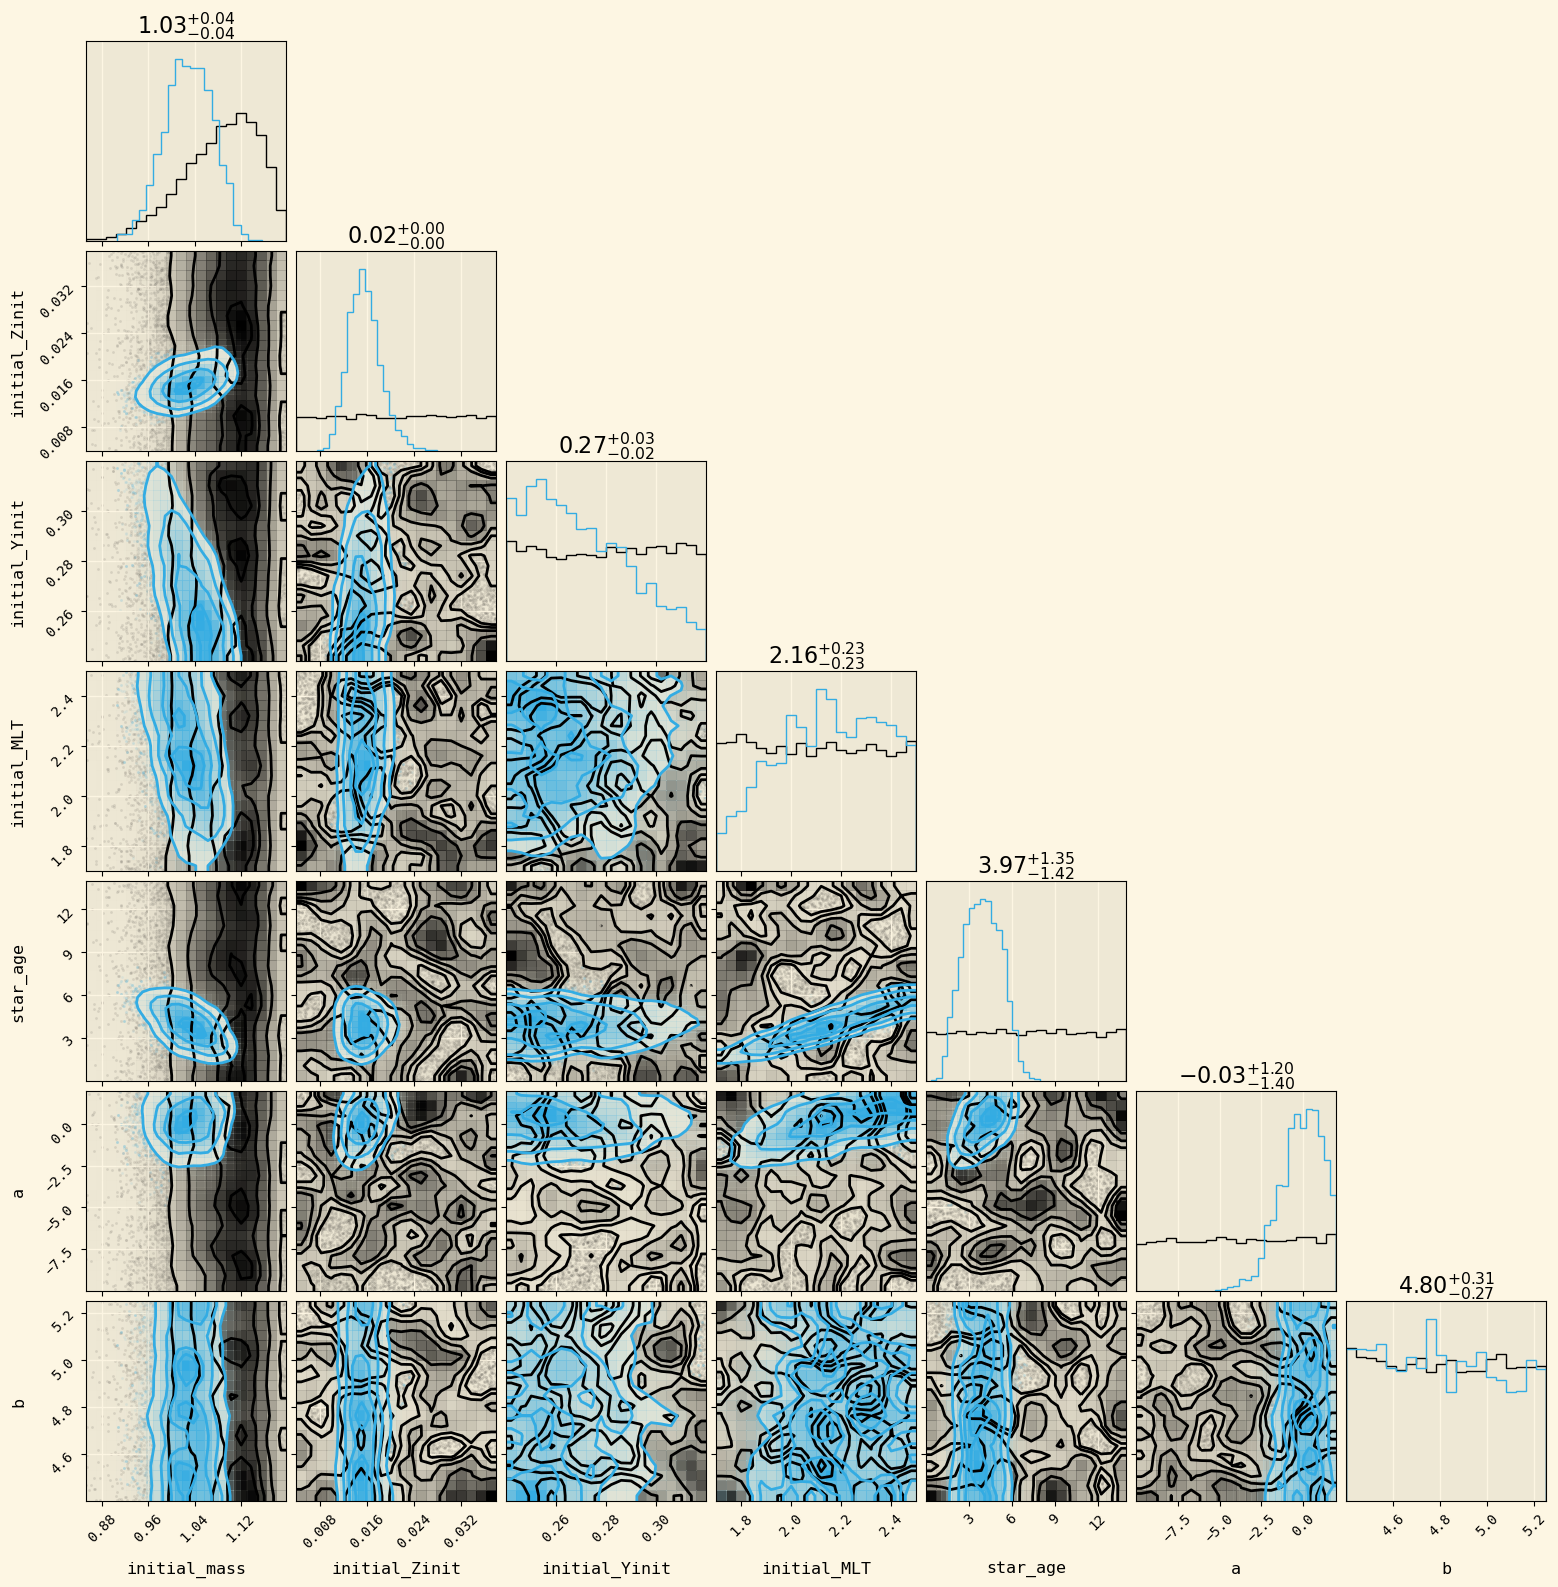

In [22]:
def inspect_star(star_name):

    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']
    
    mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=5, b=2)
    
    Zinit_prior = prior_funcs.custom_uniform_prior(0.004, 0.038)
    
    Yinit_prior = prior_funcs.custom_uniform_prior(0.24, 0.32)
    
    MLT_prior = prior_funcs.custom_uniform_prior(1.7, 2.5)
    
    age_prior = prior_funcs.custom_uniform_prior(0.03, 14)
    
    a_prior = prior_funcs.custom_uniform_prior(-10, 2)
    
    b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)
    
    
    priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    
    size = 10000
    prior_samples = np.array([prior.rvs(size=size) for prior in priors])
    legend_labels = []
    corner_color = 'black'
    figure = corner.corner(prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
    
    star_json = f'powerpuff/{star_name}/{star_name}_l0.json'
    
    star_df = pd.read_json(star_json).dropna(axis=1)

    with open(f'powerpuff/{star_name}/{star_name}_results/{star_name}_samples.pkl', 'rb') as fp:
        samples = pickle.load(fp)

    
    corner.corner(samples['samples'], fig=figure, color=star_colour, hist_kwargs={'density':True}, smooth=True,show_titles=True);
    plt.savefig(f'powerpuff/{star_name}/{star_name}_results/{star_name}_posterior.png', bbox_inches='tight',dpi=200)
    
    plt.show()


    
inspect_star(star_name)

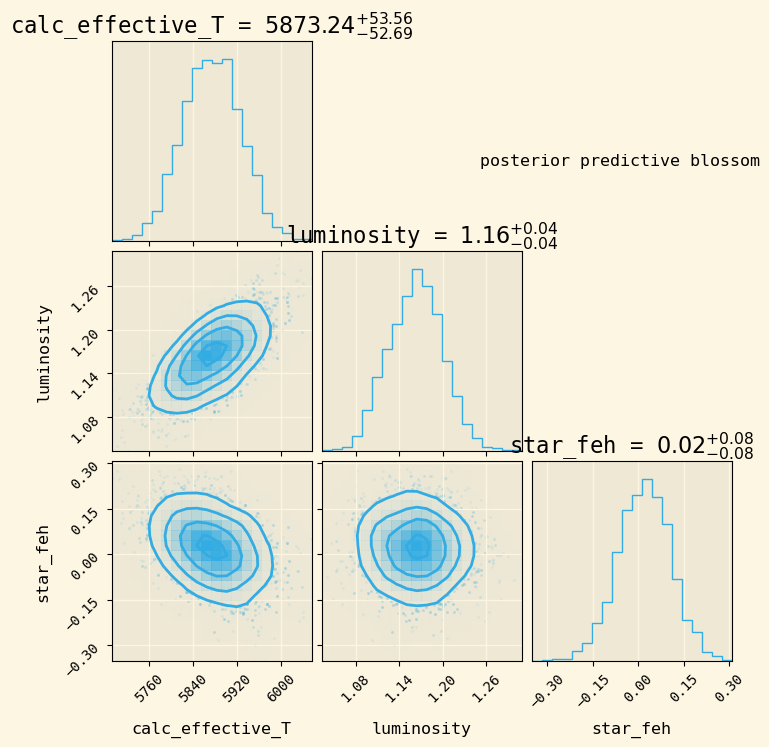

In [24]:
def posterior_pred(pitchfork, star_name):

    with open(f'powerpuff/{star_name}/{star_name}_results/{star_name}_samples.pkl', 'rb') as fp:
        samples = pickle.load(fp)

    star_json = f'powerpuff/{star_name}/{star_name}_l0.json'
    
    star_df = pd.read_json(star_json).dropna(axis=1)
    
    star_vals_df = star_df.iloc[[0]]
    
    star_uncs_df = star_df.iloc[[1]]
    
    star_obs_vals_df = star_vals_df.drop(['dnu', 'nu_max'], axis=1)
    
    star_obs_uncs_df = star_uncs_df.drop(['dnu', 'nu_max'], axis=1)
    
    nu_max = star_df["nu_max"].values[0]
    
    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

    samples_df = pd.DataFrame(samples['samples'], columns=labels)

    preds_array = pitchfork.predict(samples_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']])
    output_labels = ["calc_effective_T", "luminosity", "star_feh"] + [
        f"nu_0_{i}" for i in range(6, 41)
    ]
    
    preds_df = pd.DataFrame(preds_array, columns=output_labels)


    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    figure = corner.corner(preds_df[["calc_effective_T", "luminosity", "star_feh"]], labels = ["calc_effective_T", "luminosity", "star_feh"], color=star_colour, hist_kwargs={'density':True}, smooth=True,show_titles=True);
    
    plt.suptitle(f'posterior predictive {star_name}', x=0.8, y=0.8)

    plt.savefig(f'powerpuff/{star_name}/{star_name}_results/{star_name}_posterior_predictive.png', bbox_inches='tight',dpi=200)
    plt.show()



posterior_pred(pitchfork, star_name)